# Using Design of Experiments (DoE)

What follows is the notebook that you will use to analyse your results. Use the arrow keys to move up and down and press shift-enter on each box to run it (it has run if you see `In [1]` on the left hand side). Follow the instructions in here. 

Watch this video explainer first [[!!]]

If you have problems my office is [[!!]] and my office hours are [[!!]]. Or on zoom...

Do not worry too much about understanding how the python functions work, instead focus on what they do. (However, if you are a programmer, the functions are in doenut.py). 

**!! TODO add in guides for interpreting the 4D contour plots**

In [1]:
# first we import some useful libraries
import numpy as np # this is numerical python and contains useful maths functions
import pandas as pd # this imports excel files and builds tables called dataframes
import random # gives you random numbers
import doenut # Design of Experiments Numerical Analysis Toolkit, this is what you will use to do the DoE analysis
from matplotlib import pyplot as plt # contains plotting functions
from sklearn.linear_model import LinearRegression # this scikit-learn and contains machine learning functions.
# Here we are using the model: LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

def my_function(df_1):
    """This function is for including the extra terms in your model
    This model has no extra terms so is an empty function"""
    pass
    return df_1

In this experiment you will investigate the S$_{\mathrm{N}}$Ar reaction of 2,4-difluoronitrobenzene with pyrrolidine. This reaction can substitute one or both of the fluorine atoms of the starting material with pyrrolidine, and the aim of the experiment is to investigate how changing the reaction conditions varies the distribution of the three products.

The desired product is the ortho-substituted molecule, the para and di-substituted products are impurities. 

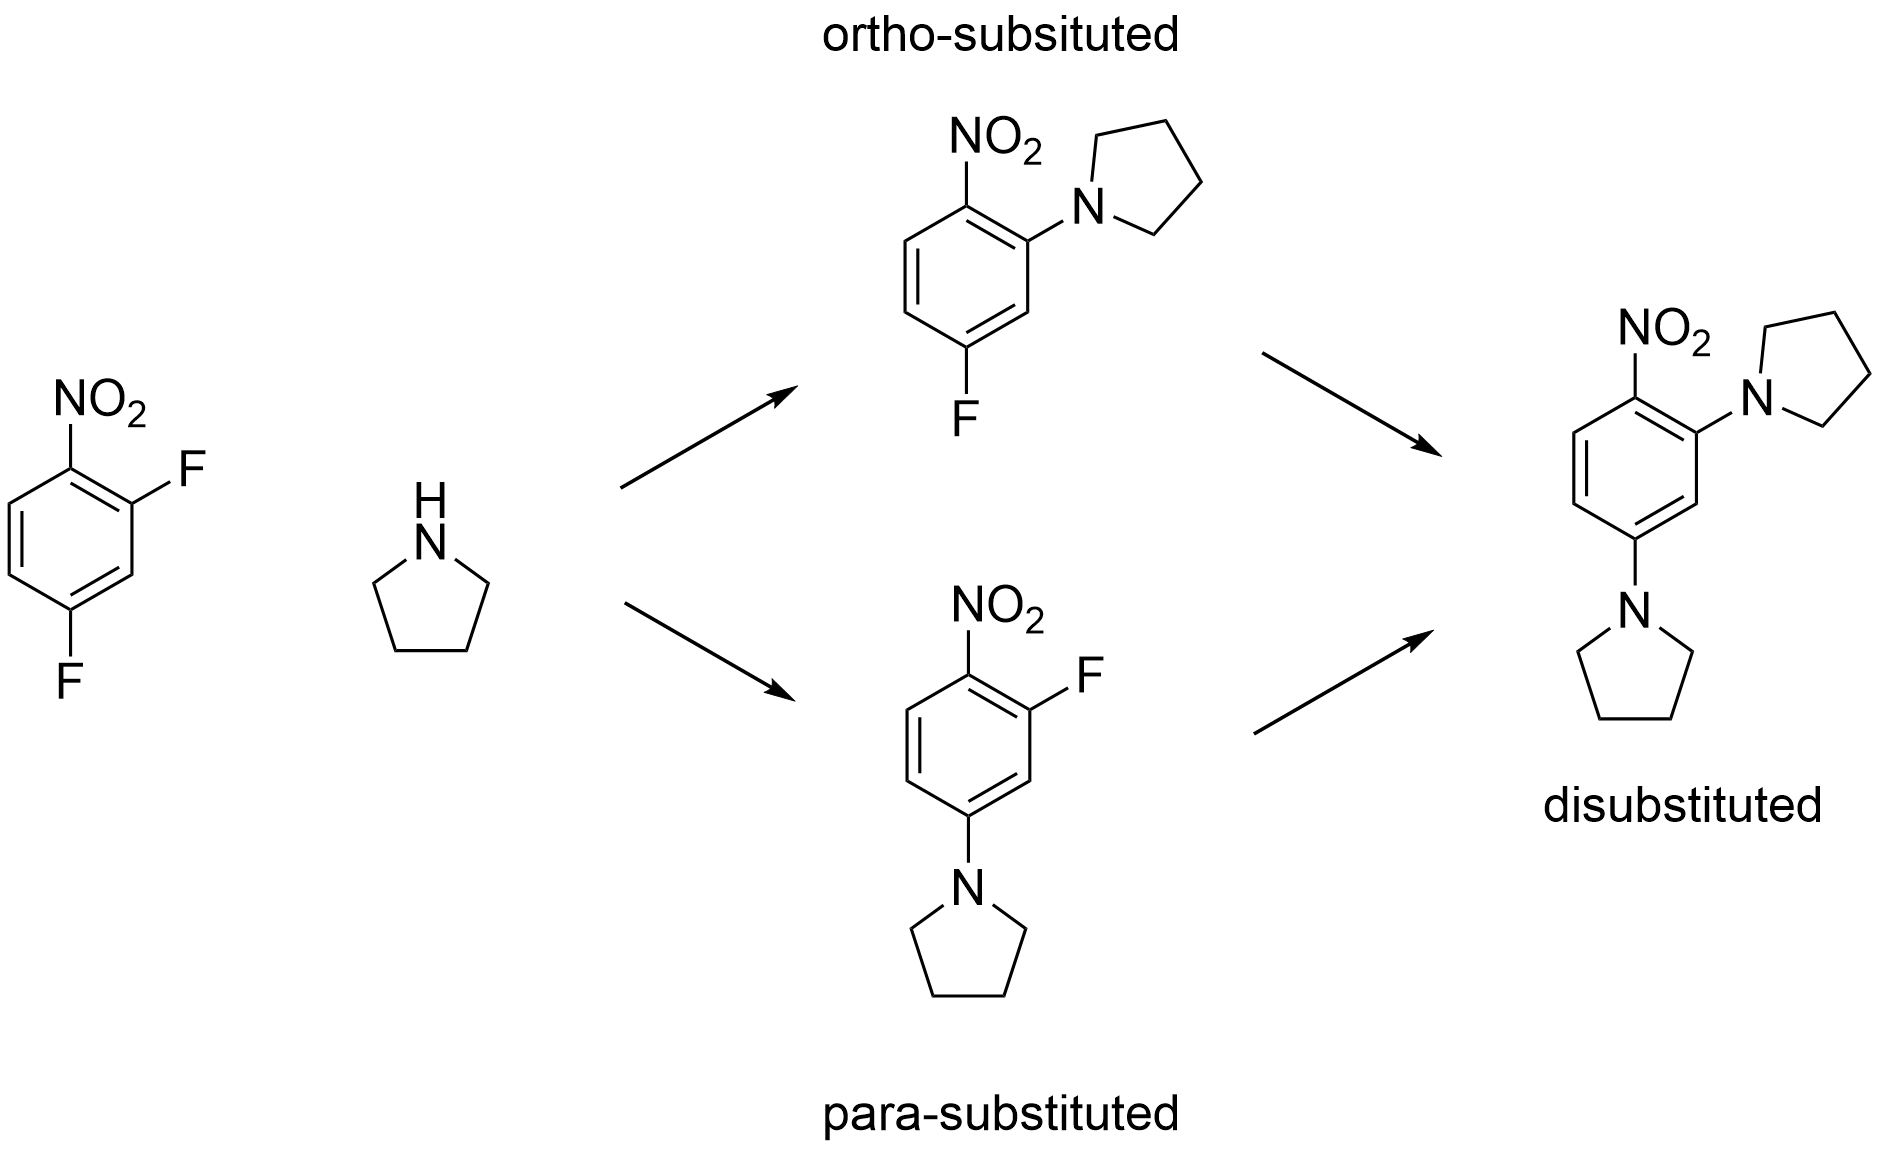

Rather than altering these things one-by-one, you are going to use a technique called Design of Experiments (DoE) to figure out the optimal reaction conditions. Your task is to maximise the amount of ortho substituted product formed and to minimise the amount of para-product and starting material.

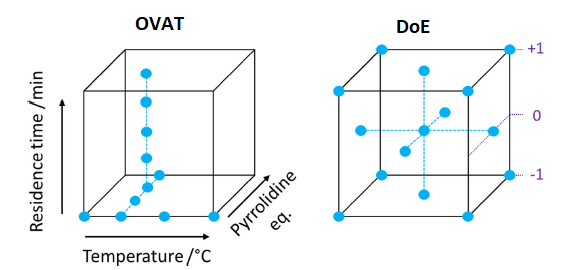

There are 5 factors that we have identified that can affect the outcome of this experiment:

1. residence time
2. temperature
3. equivalents of pyradine
4. concentration of 2,4-difluoronitrobenzene
5. concentration of triethylamine

We have chosen to keep the last two factors constant (the concentrations), so only have 3 factors. 

We used a *face-centered cubic* design, so should have had three levels for each factor (as shown in the figure above (right)).

The factors investigated and the levels chosen were:
1. residence time: 0.5, 2, 3.5 minutes
2. temperature: 30, 50, 70 $^\circ$C
3. equivalents of pyrrolidine: 2, 6, 10

**If you used different levels to this, change the code when you plot the results.**


The output we wish to maximise is the amount of the *ortho*-product, whilst minimising the amount of impurities. This is an *opimisation problem*.

**In the box below, make sure that the name of the xlsx file matches your file.**

In [2]:
df = pd.read_excel("edited_original_data.xlsx")

The code in the box above loads in your excel file, which is the name in the brackets. It uses a *function* called `read_excel()`, which does exactly what it sounds like. This function comes from a module, which is a set of functions written by someone else that we can use. This module is called pandas, but if you look above we gave it the short name `pd`. 

This function reads your excel file into something called a *dataframe*, which is panda's version of a table. It is generally better to keep your results in a read-only excel file and only use python to manipulate them, so you don't accidentally delete any of your results. 

We have called this dataframe: `df`. 

Type `df` in the box below to have a look at your data.

In [3]:
df

,Run,Run order,Residence time /min,Temperature /°C,Pyrrolidine eq.,SM /%,ortho /%,para /%,di /%
0,N1,3,0.5,30,2,79.7,20.3,0.0,0.0
1,N2,7,3.5,30,2,36.3,60.0,0.0,3.6
2,N3,12,2.0,30,6,29.6,66.4,0.0,4.1
3,N4,16,0.5,30,10,52.7,44.6,0.0,2.7
4,N5,2,3.5,30,10,10.9,83.9,0.0,5.2
5,N6,8,2.0,50,2,34.0,62.0,0.0,4.0
6,N7,13,0.5,50,6,41.2,55.3,0.0,3.5
7,N8,1,2.0,50,6,13.8,80.9,0.0,5.3
8,N9,11,2.0,50,6,14.9,79.9,0.0,5.2
9,N10,17,2.0,50,6,14.9,79.9,0.0,5.2


This should bring up a table that looks a lot like an excel table. 

The column headings should be labelled:  Residence time/min, Temperature /°C and Pyrrolidine eq. SM/%, ortho /%, para /% and di /%. 

If there are any NaN terms, go back to your excel document, copy it sideways and make sure that there are no gaps or empty rows.

### Setting up the inputs

First we make two new dataframes:

1. inputs to the model
2. responses given by the model

The code below will do this for you if you have correctly named the columns.

Here we rename the columns of the inputs and responses.

**Make sure that if you have used different column headings that you change the names of the column headings to your own**

In [4]:
# this makes a new dataframe called inputs
inputs = pd.DataFrame({'Time': df['Residence time /min'], # sets input 0 to Time
                                   'Temp': df['Temperature /°C'], # sets input 1 to Temp
                                   'Eq': df['Pyrrolidine eq.']}) # sets input 2 to Eq
# this makes a new dataframe called responses
responses = pd.DataFrame({'ortho': df['ortho /%'], # sets response 0 to ortho
                        'para': df['para /%'], # sets response 1 to para
                        'di': df['di /%']}) # sets response 2 to di

# 0. DoENUT: Design of Experiments Numerical Utility Toolkit 

There are a few proprietary programs that will help you choose and set up a design, Modde is one, and you will likely come across it if you got to work in industry. 

Here we will use an open-source toolkit called DoENUT which can help you do the data analysis for a DoE experiment. 

Like pandas, DoENUT is a module of python functions. We use it thus:
`doenut.dunk()`, which tells python to go to the doenut module and find the function called `dunk`.

# 1a. Look at the data: inputs and responses

Lets have a look at inputs and features. Type the word `inputs` and `responses` into the two boxes below to see what is in these dataframes

In [5]:
inputs

,Time,Temp,Eq
0,0.5,30,2
1,3.5,30,2
2,2.0,30,6
3,0.5,30,10
4,3.5,30,10
5,2.0,50,2
6,0.5,50,6
7,2.0,50,6
8,2.0,50,6
9,2.0,50,6


In [6]:
responses

,ortho,para,di
0,20.3,0.0,0.0
1,60.0,0.0,3.6
2,66.4,0.0,4.1
3,44.6,0.0,2.7
4,83.9,0.0,5.2
5,62.0,0.0,4.0
6,55.3,0.0,3.5
7,80.9,0.0,5.3
8,79.9,0.0,5.2
9,79.9,0.0,5.2


# 1b: Look at the data: replicate plot

The first thing any good scientist does when starting data analysis is to sanity check the data by looking at it. 

We start by plotting the experiment number against the response for ortho (this is the yield of the ortho product). If you ran your experiments in a randomized order, then there should be no pattern in this plot of the results. If there is a pattern (and you randomized the run order) then there is a time-related bias in your results. This is an error. 

Also, you ideally want a large spread of values for your yeild to allow the program to build a good model. 

Finally, you want to check that your experimental methodology is correct, so you should have repeated some experiments, these are called replicates. If you have run some, the replicate experiments are plotted in red and should be close to each other (only the first set of replicates will be found). 

To plot the replicate plot we use the `doenut` function `replicate_plot` and we must give it the input dataframe (called `inputs`), the response dataframe (called `responses`) and the key which is the column label for the response we want to plot. `ortho` in this instance. 

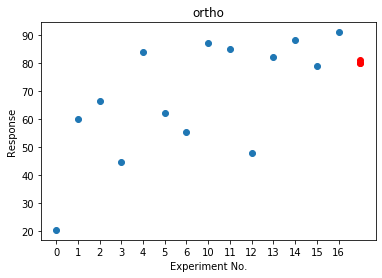

In [7]:
# this function plots the raw response data for each experiment
doenut.replicate_plot(inputs, # the input dataframe
                      responses, # the response dataframe
                      key="ortho") # this selects the ortho column of the response dataframe
# key has the options 'ortho', 'para' and 'bi'

# 3. Fit a simple model

Now that we know that the data is good, we shall build our first model!

A model relates input factors to output responses.
$$
inputs \rightarrow model \rightarrow outputs
$$

A very simple model would be something like this:
$$
outputs = \beta_0 + \beta_1 input
$$
which is simply the equation for a straight line:
$$
y = m x + c
$$,
where $c$ and $\beta_0$ are the intercept and $m$ and $\beta_1$ are the gradient.

When you fit the equation of a line to 2D data, you are building a very simple model to relate the output, $y$, to the input, $x$.

You can extend this to an arbitrary size of dimensions of your data. For example, if you have 3D input data, you could build a model from this equation:
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3
$$
which would require you to produce 4D plots to look at it. (As an aside, the field of machine learning is concerned with building models for very high dimensional data). 

This is a model of order 1 as all the variables are $x^1$ or below. (N.B. the first term is $\beta_0 x^0 = \beta_0$, and is called the *intercept*). 

We shall start with a very simple model using only the three input factors:
1. Time: `inputs['Time']`, $t$
2. Temp: `inputs['Temp']`, $T$
3. Eq: `inputs['Eq']`, $E$

The model fitted below is this:
$$
y_{ortho} = \beta_0 + \beta_1 t + \beta_2 T + \beta_2 E
$$

The code below will fit a model for the yeild of the ortho product ($y_{ortho}$ and `responses['ortho']`) and gives you the *correlation correficiant*, $R^2$, which is a number usually between 0 and 1. A perfect model would score 1.0, a score of 0.0 indicates that the model is just predicting the mean of the dataset. Values of less than 0 are possible and indicate that you've made a huge mistake!

**In this field an $R^2$ of more than 0.5 is needed for you to have a good enough model! The higher $R^2$, the better the fit of your data.**



*Notes on the function `doenut.train_model()`*:
It returns:
1. a model fitted to your data: `original_model`
2. the inputs given to it: `inputs_used`
3. the $R^2$ of that model: `original_model_R2`
4. a set of predictions that the model gives for your original data: `predictions`.

The inputs to the function `doenut.train_model()` are:
1. the inputs: `inputs`
2. the outputs: `responses['ortho']`. By typing either 'ortho', 'para' or 'di' in the square brackets you can select the output you want to model. 
3. `test_responses`: if you have a separate set of test data you can input it here to try your model out on that
4. do_scaling_here: whether to scale the data. You do not need to do this in this work.
5. `fit_intercept`: whether or not to fit the intercept. In this work you always want to fit the intercept.
6. `verbose`: this is a common setting in coding, if true it means run in verbose mode and many bits of information are printed to the screen. 

In [8]:
original_model, inputs_used, original_model_R2, predictions = doenut.train_model(
    inputs, 
    responses['ortho'], 
    test_responses=None,
    do_scaling_here=False,
    fit_intercept=True,
    verbose=True)

R squared for this model is 0.827


To see what type of model the original model is, type `original_model` in the box below. 

In [9]:
original_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can find out what the coefficients $\beta_0, \beta_1$ and $\beta_2$ are by typing original_model.coef_ below.

In [10]:
original_model.coef_

array([10.50666667,  0.5635    ,  2.7725    ])

And we type `original_model.intercept_` to get the intercept, $\beta_0$

In [11]:
original_model.intercept_

4.370784313725466

We can calculate the $R^2$ coefficient by using the function `score()`, as written below.

In [12]:
original_model.score(inputs,responses['ortho'])

0.827221549613163

The $R^2$ above might well be a good value, but that only tells us that the model is good at fitting the data, it doesn't tell us if the if we have trained a good model for predicting new data. For that we need to calculate the $R^2$ for test data, which is often called $Q^2$ in this field.

## 4. Calculate $Q^2$ for a simple order 1 model

**We want models that learn general rules from our training data, which we can then use to predict output values for unseen data.**

**$Q^2$ is the correlation coefficient on the test dataset.**

After you have made a model, it is common to test it on data that it was not trained on, this is the test dataset. If you have a lot of data, you would commonly put some of it aside for use only to testing models. However, chemistry data is hard to come by, and we want to use our data as efficiently as possble. 

**$Q^2$** **is a measure of how good a model is at predicting the output for new/unseen input data. $R^2$ is a measure of how good a model is at fitting the input to output data for that data the model was trained on.**

Now we train the saturated model using a different function that will calculate $Q^2$ which is a measure of how good the model is at predicting on unseen/new data. We want a predictive model, rather than one that just describes the data, as we want it to predict the conditions for maximum yeild, not just tell us what our yield was!

To get new data, we could go back to the lab (Yay!) or instead we can use our data intelligently. 

**$Q^2$ is calculated by leaving one point out as a test set.**

We use the *leave one out validation* method (yes, that is the technical term!). We take a single point out of our dataset, train the model on the rest and then see how well that model does at predicting the missing point. We then repeat, leaving out a different point until all points have been excluded. The single point is the test set for each model.

For each model we trained we will have gotten a different solution with different coordinates. To get the final model, the coefficients are averaged to give an averaged model (which we call `ortho_model` in the code below. 

When you run `doenut.calc_averaged_model()` below you should see the $R^2$ coefficients for each model, and the error on the test set (i.e. the difference between what the model predicts for the missing point and what you measured). It should print out $R^2$ and $Q^2$ for the final model and plot them as a bar chart.

*doenut.calc_averaged_model usage details:*

Takes in: 
1. `inputs`: the input dataframe
2. `responses[['ortho']]`: the response data for the *ortho-*product
3. `key='ortho'`: used to calculate Q2
4. `drop_duplicates`: removes the replicate experiments
5. others as above

Outputs:
1. **the averaged model (called ortho_model below as it models the ortho-product data)**
2. predictions from the model from the inputs
3. the inputs measured (called ground_truth below)
4. coeffs: the coefficients of the models
5. R2S: a list of the $R^2$ values for each model
6. **R2: the $R^2$ correlation coefficient on the training data for the averaged model (the fitting coefficient)**
7. **Q2: the $Q^2$ correlation coefficient on the testing data for the averaged model (the predicting coefficient)**

Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.801	Ave. Error = -16.5
Left out data point 1:	R2 = 0.857	Ave. Error = -3.63
Left out data point 2:	R2 = 0.873	Ave. Error = 10.5
Left out data point 3:	R2 = 0.862	Ave. Error = -13.2
Left out data point 4:	R2 = 0.852	Ave. Error = -0.916
Left out data point 5:	R2 = 0.86	Ave. Error = 5.03
Left out data point 6:	R2 = 0.854	Ave. Error = 2.59
Left out data point 7:	R2 = 0.881	Ave. Error = 12.9
Left out data point 10:	R2 = 0.85	Ave. Error = 3.17
Left out data point 11:	R2 = 0.856	Ave. Error = 5.89
Left out data point 12:	R2 = 0.854	Ave. Error = -8.72
Left out data point 13:	R2 = 0.855	Ave. Error = -4.17
Left out data point 14:	R2 = 0.861	Ave. Error = 9.52
Left out data point 15:	R2 = 0.858	Ave. Error = 5.21
Left out data point 16:	R2 = 0.92	Ave. Error = -25.3
R2 overall is 0.823
Mean of test set: 68.9
Mean being used: 70.19411764705882
Sum of squares of the residuals (explained variance) is 1665.762544742608

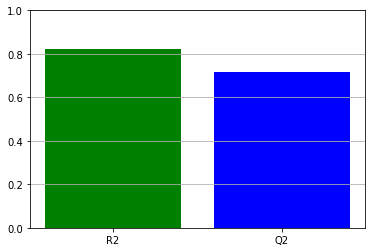

In [13]:
ortho_model, predictions, ground_truth, coeffs, R2s, R2, Q2 = doenut.calc_averaged_model(
    inputs, 
    responses[['ortho']], 
    key='ortho',
    drop_duplicates=True,
    use_scaled_inputs=False,
    fit_intercept=True,
    do_scaling_here=False)

You should see a series of $R^2$ that are roughly similar for each model.

**$Q^2$ is usually below $R^2$. A good model has a $Q^2$ above 0.5 and is not far from the value of $R^2$**

As an example, a model with an $R^2$ of 0.8 and an $Q^2$ of 0.7 would be a good model, a model with an $R^2$ of 0.8 and an $Q^2$ of 0.6 would be OK.

A model with a very high $R^2$ value and a low $Q^2$ value is an *overfitted model*. Overfitting is when a model is very good at fitting your measured data but bad at predicting on novel data. We want models that can learn the general rules from our data and then use those rules to predict what will happen with new data.

As an example, an over-fitted student would be someone who had memorised every S$_{\mathrm{N}}$AR reaction they had ever seen, but had failed to learn the general rules. In a test, the over-fitted student would fail on any reaction they hadn't already seen. 

Whereas, a better student would have learned the general rules of how nucleophilic aromatic subsitution works and would be able to work out a mechanism if shown a reaction they had never seen before. 

As another example, a model with an $R^2$ of 0.95 and a $Q^2$ of 0.6 is an over-fitted model. And note that, if we had only looked at the $R^2$ , we would think it was a great model. 

In the design of experiments methodology, we do not make a single model, we make several and pick the best one based on the values of $R^2$ and $Q^2$ (and some other constraints that we sadly do not have time to cover here!).

The aim is to maximise the value of $Q^2$.

### 5. Build a map of reaction space

As a recap:
The inputs to the model are: 
1. flow time, 
2. temperature, 
3. pyrrolidine equivalents

The responses are: 
1. yield of the ortho substituted product, 
2. yield of the para substituted product
3. yield of the di-subsituted product

Now we have a good model hopefully with good $Q^2$ and $R^2$ values, we want to use the model to predict the outputs not just for a few input points , but for a whole range of them, so we can make a map of reaction space and then use it to find the conditions that would give us the best yield of our product.

To do this, we have to give the model a series of values for the inputs and we plot what is called *4D contour plot*. (I prefer to refer to it as a map as it ends up being a map of where to go next). 

Setting up these plots may be a little involved, so read the instructions below carefully. You should ends up with a nice colourful figure with 3 plots on it. These graphs are called 4D plots as they contain 4 dimensions of data: 
1. residence time (the x axis)
2. temperature (the y axis)
3. pyrollidine equivalents (the 3 graphs show 3 values of this)
4. the yield at each point (the colour and contours). 

Notes on: `doenut.four_D_contour_plot`()

Inputs:

Things you will have to change are labelled in bold.

1. `unscaled_model`: the model you just trained
2. `x_key`: name in the dataframe for the input to go on the x axis
3. `y_key`: name in the dataframe for the input to go on the y axis
4. `c_key`: name in the dataframe for the input to be the constant for each plot (i.e. equivalents of pyrollidine)
5. `x_limits`: **limits of the x axis: min and max time values** Put in your minimum and maximum res time like this: `[1,3]` for a minimum of 1 minute and maximun of 3 minutes. If you get stuck, run the code in the cell below to read out the minimum and maximum times from your dataframe. 
6. `y_limits`: **limits of the y axis: min and max temperatures** Put in your minimum and maximum temperature
7. `constants`: **values of pyrollidine to keep constant for the 3 plots** Pick 3 values of pyrollidine equivalents to plot. I would suggest the minimum you tested, the maximum you tested and one in the middle. 
8. `n_points`: how many points in the x and y direction to use to build the map
9. `my_function`: a little function to add higher order terms if the model requires it
10. `fig_label`: label for the overall figure    
11. `x_label`: label for x axes
12. `y_label`: label for y axis
13. `constant_label`: label for top of subplots
14. `z_label`: label for the heatbar
15. `cmap`: colourmap for the plot (yes you can change it, do not spend hours playing around with the colourscheme!)
16. `num_of_z_levels`: **number of levels for the contours. You will want one more than you think you do** If you want 10 colours, you need 11 contours. Change this to get the desired graph.
17. `z_limits`: **limits for the yield, i.e. minimum and maximum.** Change to get the desired graph. 

If you don't see any contours, change the z_limits to be closer to your minimum and maximum. 

If you have only one block of colour, increase the number of z_levels.

If you get weird numbers on the heatscale at the side, change the number of z levels. 

Output: 
1. a beautiful graph
You may need to set the x_limits (minimum and maximum of the Time period you tested), y_limits (minimum and maximum of the temperature you tested). 

The constant is Eq in this graph, so this value is kept constant in each subfigure.

In [14]:
# this grabs information from the dataframes
min_Time = inputs["Time"].min()
max_Time = inputs["Time"].max()
print(f"Time range is [{min_Time},{max_Time}]")
min_Temp = inputs["Temp"].min()
max_Temp = inputs["Temp"].max()
print(f"Temp range is [{min_Temp},{max_Temp}]")
min_Eq = inputs["Eq"].min()
max_Eq = inputs["Eq"].max()
print(f"Eq range is [{min_Eq},{max_Eq}]")
key='ortho'
min_yield = responses[key].min()
max_yield = responses[key].max()
print(f"{key}-product yeild range is [{min_yield},{max_yield}]")

Time range is [0.5,3.5]
Temp range is [30,70]
Eq range is [2,10]
ortho-product yeild range is [20.3,91.0]


<Figure size 1440x864 with 0 Axes>

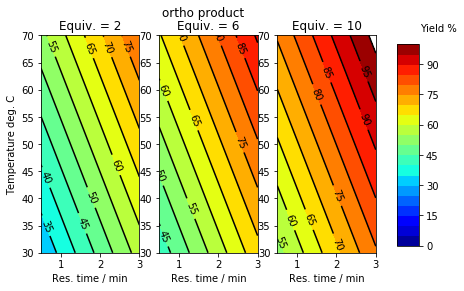

In [15]:
doenut.four_D_contour_plot(
    unscaled_model=ortho_model, # you may need to change this
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], # you may need to cahnge this
    y_limits=[30,70], # you may need to change this
    constants=[2,6,10], # you may need to change this
    n_points=60,
    my_function=my_function,
    fig_label='ortho product',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='Equiv.',
    z_label = 'Yield %',
    cmap='jet',
    num_of_z_levels=21, # you may need to change this
    z_limits=[0,100]) # you may need to change this

**To save a figure, right click on it and select 'save image as'. You will need some contour plots for your report!**

### Is an order 1 model good enough?

The function `doenut.plot_observed_vs_predicted()` allows us to plot the measured response (what you measured in the flow experiment) against the response predicted from the model you just trained (`predictions`).

You may notice that your data seems to follow a curve rather than a straight line. This implies that there are *interaction effects* that we need to include in the model.

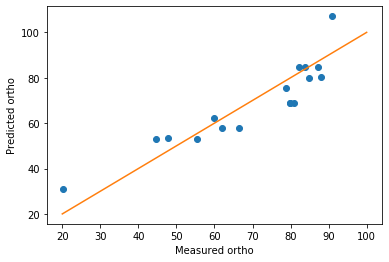

In [19]:
model_1_graph= doenut.plot_observed_vs_predicted(responses['ortho'], 
                               ortho_model.predict(inputs),
                               range_x=[],
                               label='ortho')

This model hasn't included interaction effects. One of the great things about doing DoE experimentation is that we can pick up the effect of interactions with only a few experiments, so lets see what interactions effects this system has.

You should see straight lines in the graph above, as we only have terms of the format $x$, $y$, $z$, below we will add in the cross and square terms

The $R^2$ above might well be a good value, but that only tells us that the model is good at fitting the data, it doesn't tell us if the if we have trained a good model for predicting new data.

This function allows us to plot the measured response (what you measured in the flow experiment) against the response predicted from the model you just trained.

You may notice that your data seems to follow a curve rather than a straight line. This implies that there are interaction effects that we need to include in the model. We add in some of these interaction effects in the next section. 

# 6. Training a higher order model

The inputs to the model are called $features$, these include the input factors you've already used, but they can also include features that you can create from your inputs. 

For example, for a system with 3 input factors, $x_1$, $x_2$ and $x_3$ we could create a model like this:

!!! NTS add more details here

$y = \beta_0 + \beta_1  x_1 + \beta_2  x_2 + \beta_3 x_1  x_2 + \beta_4  x_1^2 + \beta_5  x_2^2$

We don't know the underlying equation (the model), so we do not know the values of the $\beta$, this is what we are going to learn from the data.

You may noticed that we could keep going, we could have highers powers (e.g. $\beta_i  x_a^3$ or $\beta_j  x_a^3  x_b^2$ etc). We make the *assumption* that this system is not that complicated, so we will not consider any terms with a power higher than 2, i.e. we are setting all other possible $\beta$ values to 0. In this feild the terms we add are called *polynomial features* and thus you can describe this process and only considering polynomial features up to power 2. 

A *saturated model* is one with all the polynomial features (up to our desired power) included. The model written above is a saturated model for two inputs and one output. 

Terms of the format $x_j^2$ are called *square terms* and show second order effects in the main term.

Terms of the format $x_i x_j$ are called *interaction terms*, and these show the interaction between the inputs $x_i$ and $x_j$. 

Both are very importent for understanding the complexity of the system and we are using [multiple factor at a time] experimentation to discover these.


$y = \beta_0 + \beta_1 x_1 + ...$

The model we will build does not know algebra, so we have to give it each of these polynomial features as well. We will later fit the model to these features and figure out which ones are significant. 

To do this we simply add the new terms (features) to the input dataframe. 

To add a column to a dataframe we use the following construction:
`dataframe['name of new column'] = name_of_data_to_be_added`

In this case, we use something like this:
`inputs['Time*2'] = inputs['Time']*inputs['Time']`

The code below adds in the squared terms to your input dataframe.

In [20]:
inputs['Time**2']= inputs['Time']*inputs['Time'] # makes a new column called Time**2
# from multiplying the Time column by itself
inputs['Temp**2']= inputs['Temp']*inputs['Temp'] # does Temp*Temp
inputs['Eq**2']= inputs['Eq']*inputs['Eq'] # does Eq*Eq

# This is needed to create the 4D contour plots
# it just tells the function that we have squared terms
def my_function_second_order(df_1):
    df_1['Time**2'] = df_1['Time']*df_1['Time']
    df_1['Temp**2'] = df_1['Temp']*df_1['Temp']
    df_1['Eq**2'] = df_1['Eq']*df_1['Eq']
    return df_1

In [21]:
# this code will print out inputs so you can have a look at it.
inputs

,Time,Temp,Eq,Time**2,Temp**2,Eq**2
0,0.5,30,2,0.25,900,4
1,3.5,30,2,12.25,900,4
2,2.0,30,6,4.00,900,36
3,0.5,30,10,0.25,900,100
4,3.5,30,10,12.25,900,100
5,2.0,50,2,4.00,2500,4
6,0.5,50,6,0.25,2500,36
7,2.0,50,6,4.00,2500,36
8,2.0,50,6,4.00,2500,36
9,2.0,50,6,4.00,2500,36


### 6a. Build a second order model for the ortho model

Now that we've expanded the input dataframe, we can just run the code we used above to create a new model.

Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.932	Ave. Error = -8.79
Left out data point 1:	R2 = 0.956	Ave. Error = 5.37
Left out data point 2:	R2 = 0.954	Ave. Error = 0.27
Left out data point 3:	R2 = 0.952	Ave. Error = -5.12
Left out data point 4:	R2 = 0.959	Ave. Error = 8.34
Left out data point 5:	R2 = 0.954	Ave. Error = -1.48
Left out data point 6:	R2 = 0.953	Ave. Error = -1.22
Left out data point 7:	R2 = 0.953	Ave. Error = 1.69
Left out data point 10:	R2 = 0.951	Ave. Error = -0.135
Left out data point 11:	R2 = 0.952	Ave. Error = 0.135
Left out data point 12:	R2 = 0.95	Ave. Error = -0.208
Left out data point 13:	R2 = 0.955	Ave. Error = 4.78
Left out data point 14:	R2 = 0.951	Ave. Error = -1.62
Left out data point 15:	R2 = 0.976	Ave. Error = 15.1
Left out data point 16:	R2 = 0.987	Ave. Error = -18.4
R2 overall is 0.956
Mean of test set: 68.9
Mean being used: 70.19411764705882
Sum of squares of the residuals (explained variance) is 798.64380299

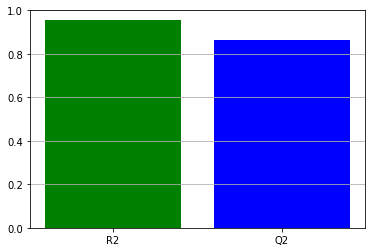

In [22]:
second_order_ortho_model, predictions, ground_truth, saturated_coeffs, R2s, R2, Q2 = doenut.calc_averaged_model(
    inputs, 
    responses[['ortho']], 
    key='ortho',
    drop_duplicates=True,
    use_scaled_inputs=False,
    fit_intercept=True,
    do_scaling_here=False)

### Questions to consider:

1. Which model has the better $R^2$ the first order or the second order one?
1. Which model has the better $Q^2$ the first order or the second order one?
1. Which model is better?

(You will want to report the R2 and Q2 for the two models in your report). 

### 6.b Create the 4D contour plot (reaction conditions map)

Now, we run the contour plot code from above. 

N.B. the model input into the function has been changed and the `my_function` has been changed to one that include the second order terms.

<Figure size 1440x864 with 0 Axes>

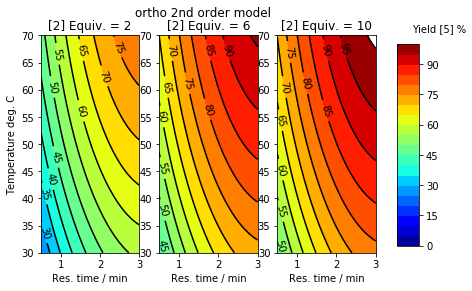

In [23]:
ortho_result = doenut.four_D_contour_plot(
    unscaled_model=second_order_ortho_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function_second_order,
    fig_label='ortho 2nd order model',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=21,
    z_limits=[0,100])

### Questions to consider:

4. What is the difference between the contour plots for the first order and second order models? Do you know why?

### Task for the report:

The design of experiment proceedure is to:
1. Design: design which experiments to do (this was done for you)
2. Experimental work: run those experiments in the lab (you did this last week!)
3. Modelling: build some models, pick the best one (you choose from your results in section 4 and 6a)
4. Prediction: use it to predict the yield for different inputs (this is the 4D contour maps)
5. Prediction: look at the contour plot and figure out where the optimum conditions are. You should be able to read this off the graph
6. Verification: Go back into the lab and run that experiment to see if the model works (and if you've suceeding in optimising your reaction).

You have now done steps 1-4 for the ortho product, your next task is to figure out what the reaction conditions are. 

**From the graph you plotted above, what reaction conditions would you chose to try next? Design the experiment to run.**

Put your proposed experiment to optimise the yield of the ortho product into the report.

#### 4c. Is the second order model better than the first?

We shall quickly plot the observed vs predicted data plot again.

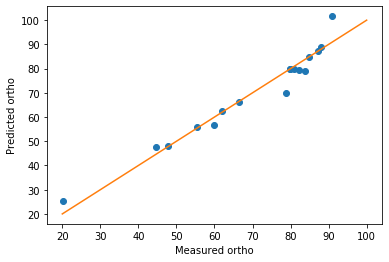

In [24]:
# This line asks the saturated model to take in the inputs we gave 
# to the system and use the model to predict what we expect
# and save that as predictions
predictions = second_order_ortho_model.predict(inputs)

# This line compares the measured values: responses['ortho']
# with the predictions from the model: predictions
doenut.plot_observed_vs_predicted(responses['ortho'], # x axis 
                               predictions, # y axis
                               range_x=[], # selects the range of x to plot, [] mean plot all
                               label='ortho') # The label to add to the x and y axes.

### Questions to consider:

5. From the observed-predicted plots, which model is better?

# para and di models

Now you've fitted a model to the ortho product, lets do the di and para products. 

You will want to copy `doenut.calc_averaged_model()` from section [[!!]] and change the reponses to di. Then use `doenut.four_D_contour_plot` with the di data. You will have to change the settings on the z_levels and z_ranges. 

Repeat for the para substituted product. 

Report your R2 and Q2 values for these models. 

Are the models valid? (R2 and Q2 above 0.5)

Where are the optimum reaction conditions for these two products? 

Finally: 

If you wanted to maximize the ortho product yield and minimize the yield of the other products, what reaction conditions would you choose. 

Put in report.

Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.924	Ave. Error = -1.54
Left out data point 1:	R2 = 0.936	Ave. Error = 0.712
Left out data point 2:	R2 = 0.93	Ave. Error = 0.215
Left out data point 3:	R2 = 0.924	Ave. Error = 0.158
Left out data point 4:	R2 = 0.932	Ave. Error = 0.504
Left out data point 5:	R2 = 0.929	Ave. Error = 0.125
Left out data point 6:	R2 = 0.928	Ave. Error = -0.01
Left out data point 7:	R2 = 0.928	Ave. Error = 0.025
Left out data point 10:	R2 = 0.925	Ave. Error = -0.01
Left out data point 11:	R2 = 0.927	Ave. Error = -0.145
Left out data point 12:	R2 = 0.927	Ave. Error = 0.192
Left out data point 13:	R2 = 0.931	Ave. Error = 0.538
Left out data point 14:	R2 = 0.925	Ave. Error = -0.235
Left out data point 15:	R2 = 0.95	Ave. Error = 1.2
Left out data point 16:	R2 = 0.974	Ave. Error = -1.75
R2 overall is 0.931
Mean of test set: 4.3933333333333335
Mean being used: 4.488235294117648
Sum of squares of the residuals (explained variance

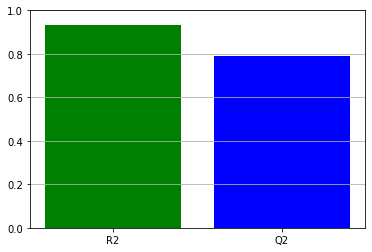

In [29]:
di_model, predictions, ground_truth, saturated_coeffs, R2s, R2, Q2 = doenut.calc_averaged_model(
    inputs, 
    responses[['di']], 
    key='di',
    drop_duplicates=True,
    use_scaled_inputs=False,
    fit_intercept=True,
    do_scaling_here=False)

<Figure size 1440x864 with 0 Axes>

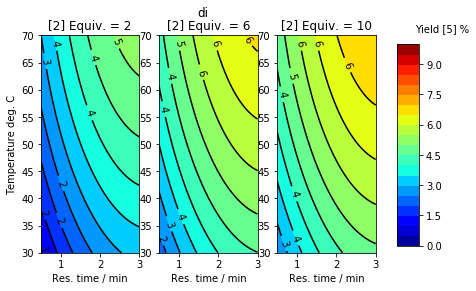

In [31]:
#def my_function(df_1):
#    df_1['Time*2'] = df_1['Time']*df_1['Time']
#    df_1['Temp*2'] = df_1['Temp']*df_1['Temp']
#    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
    #df_1['Time*Temp'] = df_1['Time']*df_1['Temp']
    #df_1['Time*Eq'] = df_1['Time']*df_1['Eq']
#    return df_1
doenut.four_D_contour_plot(
    unscaled_model=di_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function_second_order,
    fig_label='di',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=21,
    z_limits=[0,10])

Input data is 17 points long
We are using 15 data points
Left out data point 0:	R2 = 0.624	Ave. Error = 1.0
Left out data point 1:	R2 = 0.536	Ave. Error = -0.00385
Left out data point 2:	R2 = 0.544	Ave. Error = -0.34
Left out data point 3:	R2 = 0.538	Ave. Error = 0.135
Left out data point 4:	R2 = 0.602	Ave. Error = -0.869
Left out data point 5:	R2 = 0.539	Ave. Error = 0.2
Left out data point 6:	R2 = 0.573	Ave. Error = 0.74
Left out data point 7:	R2 = 0.541	Ave. Error = -0.219
Left out data point 10:	R2 = 0.558	Ave. Error = -0.565
Left out data point 11:	R2 = 0.542	Ave. Error = -0.025
Left out data point 12:	R2 = 0.551	Ave. Error = -0.419
Left out data point 13:	R2 = 0.588	Ave. Error = -0.731
Left out data point 14:	R2 = 0.495	Ave. Error = 0.515
Left out data point 15:	R2 = 0.681	Ave. Error = -1.28
Left out data point 16:	R2 = 0.563	Ave. Error = 2.04
R2 overall is 0.546
Mean of test set: 0.3
Mean being used: 0.2647058823529412
Sum of squares of the residuals (explained variance) is 9.62

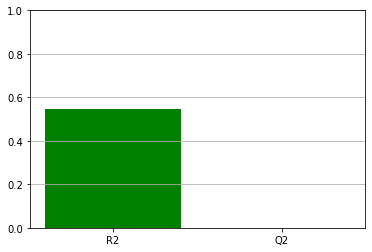

In [32]:
para_model, predictions, ground_truth, saturated_coeffs, R2s, R2, Q2 = doenut.calc_averaged_model(
    inputs, 
    responses[['para']], 
    key='para',
    drop_duplicates=True,
    use_scaled_inputs=False,
    fit_intercept=True,
    do_scaling_here=False)

C:\Users\ella_\Documents\GitHub\doenut\doenut.py:537: UserWarning: No contour levels were found within the data range.
  colors = 'black')
C:\Users\ella_\Documents\GitHub\doenut\doenut.py:542: UserWarning: No contour levels were found within the data range.
  num_of_levels, levels=levels, colors = 'black')


<Figure size 1440x864 with 0 Axes>

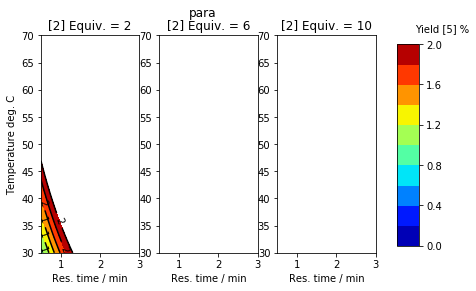

In [33]:
#def my_function(df_1):
#    df_1['Time*2'] = df_1['Time']*df_1['Time']
#    df_1['Temp*2'] = df_1['Temp']*df_1['Temp']
#    df_1['Eq*2'] = df_1['Eq']*df_1['Eq']
    #df_1['Time*Temp'] = df_1['Time']*df_1['Temp']
    #df_1['Time*Eq'] = df_1['Time']*df_1['Eq']
#    return df_1
doenut.four_D_contour_plot(
    unscaled_model=saturated_model,
    x_key='Time',
    y_key='Temp',
    c_key='Eq',
    x_limits=[0.5,3.0], 
    y_limits=[30,70], 
    constants=[2,6,10], 
    n_points=60,
    my_function=my_function_second_order,
    fig_label='para',    
    x_label='Res. time / min',
    y_label='Temperature deg. C',
    constant_label='[2] Equiv.',
    z_label = 'Yield [5] %',
    cmap='jet',
    num_of_z_levels=11,
    z_limits=[0,2])